In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
from fractions import Fraction
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh = 16
refRatio = 2
c = 1.
CFL = 0.5
nt = 1
RK = 4
deriv = 'CD'
order = 0
mu = 0.5
sigma = .1
wavenumber = 35
plot = 2
Hans = False

In [3]:
omegaF = BT.Grid(nh * refRatio)
print(Fraction(16, 64).numerator)

1


In [4]:
def Residuals(omegaF, cellNums = [], refRatio = 2, plot = 0, ct = 0):
    
    # Obtain attributes from master refined grid.
    nh_max = omegaF.nh_max
    xFine = omegaF.xCell
    
    # Create other necessary objects from master refined grid information.
    wavesF = WT.MakeWaves(omegaF)
    strings = PT.FixStrings(omegaF, np.eye(nh_max), False)
    
    ks = np.linspace(0.5, nh_max / 2, num = nh_max)
    nh_min = int(nh_max / refRatio)

    # Get save name info.
    numPoints, font, X, savePath = PT.UsefulPlotVals()
    saveName = savePath + 'FirstModes' + str(nh_min) + '.png'
    
    # Determine iterations over grid proportions and create vector for storing maximum residual norms.
    if (cellNums == []):
        iters = nh_min
    else:
        iters = 1
    print ('iters =', iters)
    residNormMax = np.zeros(iters, float)
    iterAxis = (np.arange(iters) + 1) / nh_min
    print(iterAxis)
    
    # Iterate over grid refinement proportions.
    for i in range(iters):
        print('i = ', i)
        
        # Instantiate grid with appropriate grid proportions.
        omegaAMR = BT.Grid(nh_min)
#         omegaFAMR = BT.Grid(nh_max)
        if (cellNums == []):
            finehalf = list(np.arange(i + 1))
#             finehalfF = list(np.arange(refRatio * (i + 1)))
        else:
            # Modify this for FAMR!
            finehalf = cellNums
        omegaAMR.AddPatch(refRatio, finehalf)
#         omegaFAMR.AddPatch(refRatio, finehalfF)
        
        degFreed = omegaAMR.degFreed
        xCell = omegaAMR.xCell
        hs = omegaAMR.h
        cells = omegaAMR.cells[-1]

        wavesAMR = WT.MakeWaves(omegaAMR)
#         wavesFAMR = WT.MakeWaves(omegaFAMR)

        nullspace = OT.FindNullspace(omegaAMR, wavesAMR, Hans = Hans)
#         nullspaceF = OT.FindNullspace(omegaFAMR, wavesFAMR, Hans = Hans)
        
        restrictOp = GTT.CoarsenOp(omegaAMR)
#         restrictOpF = GTT.CoarsenOp(omegaFAMR)

        # Create the propagated or non-propagated waves in space-space.
        if (ct == 0):
            exactF = wavesF
        else:
            exactF = WT.MakeWaves(omegaF, ct = ct)
        FCoefsExact = FFTT.FourierCoefs(omegaF, wavesF, exactF)
        exactAMR = restrictOp @ wavesF @ FCoefsExact
        
        if (ct == 0):
            FCoefsTest = FFTT.FourierCoefs(omegaAMR, wavesAMR @ nullspace, exactAMR, False)
        else:
            FCoefsTest = 
        testAMR = wavesAMR @ nullspace @ FCoefsTest

        resid = abs(exactAMR - testAMR)
        residNorm = TT.VectorNorm(resid, normType = 'max')

        for j in range(nh_max):

            if (plot > 2):# and (residNorm[j] > 1e-11)):
                if (j % 1 == 0):
                    fig1, ax1 = plt.subplots(figsize = [12, 4])
                    ax1.plot(xFine, exactF[:, j], lw = 1, color = PT.ColorDefault(0), label = 'Exact Fine Solution')
                    ax1.plot(xCell, exactAMR[:, j], lw = 1, color = PT.ColorDefault(1), linestyle = '--', label = 'Exact AMR Solution')
                    ax1.plot(xCell, testAMR[:, j], lw = 1, color = PT.ColorDefault(2), linestyle = ':', label = 'NUDFT AMR Solution')
                    plt.title('AMR and Fine Representations of ' + strings[j])
                    plt.xlabel('$x$')
                    plt.ylabel('Waveform')
                    plt.legend()

                    fig2, ax2 = plt.subplots(figsize = [12, 4])
                    ax2.plot(xCell, resid[:, j], lw = 1)
                    plt.title('Residuals for ' + strings[j])
                    plt.xlabel('$x$')
                    plt.ylabel('Residuals')
                    plt.show()
                    print('\n\n\n\n')    

#         PT.PlotWaves(omegaAMR, waves = wavesAMR, nullspace = nullspace)
#                     if (residNorm[j] > 1e-11):
#                         saveName1 = savePath + 'WaveReps' + str(j) + '.png'
#                         saveName2 = savePath + 'Residuals' + str(j) + '.png'
        #                 fig1.savefig(saveName1, bbox_inches = 'tight', dpi = 300, transparent = True)
        #                 fig2.savefig(saveName2, bbox_inches = 'tight', dpi = 300, transparent = True)
#                         print(exactAMR)
#                         print(testAMR)
                    
#             print('j = ', j)
        residNormMax[i] = TT.VectorNorm(residNorm, normType = 'max')
        if (plot > 1):
            numer = str(Fraction(i + 1, nh_min).numerator)
            denom = str(Fraction(i + 1, nh_min).denominator)
            fig, ax = plt.subplots(figsize = [12, 4])
            plt.plot(ks, residNorm)
            ax.grid(True, axis = 'both', zorder = 0)
            plt.yscale('log')
            plt.title(r'Residual Max Norm by Wavenumber for $\frac{' + numer + '}{' + denom + '}$ Grid Refined')
            plt.ylabel('Residual Norm')
            plt.xlabel('Wavenumber')
            plt.show()
        print('end loop i = ', i)
        print('')
        print('')
    if ((plot > 0) and (cellNums == [])):
        fig, ax = plt.subplots(figsize = [12, 4])
        plt.plot(iterAxis, residNormMax, color = PT.ColorDefault(0), lw = 1)
        plt.scatter(iterAxis, residNormMax, color = PT.ColorDefault(0), s = 8)
        # plt.plot(ks, 1e-13 * np.ones(nh_max, float))
        ax.grid(True, axis = 'both', zorder = 0)
        plt.yscale('log')
        plt.title(r'Residual Max Norm by Proportion of Grid Refined')
        plt.ylabel('Residual Norm')
        plt.xlabel('Grid Proportion')
        fig.savefig(saveName, bbox_inches = 'tight', dpi = 300, transparent = True)
        plt.show()
    return

iters = 16
[0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625 0.625  0.6875 0.75   0.8125 0.875  0.9375 1.    ]
i =  0


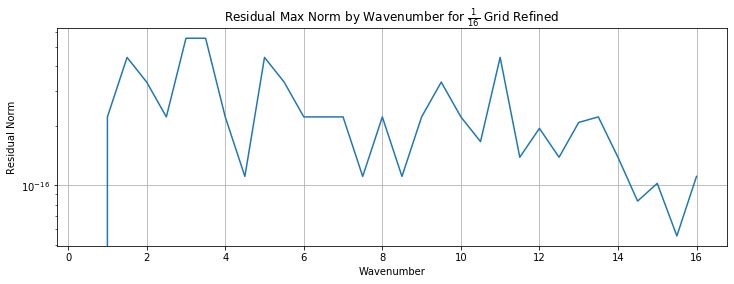

end loop i =  0


i =  1


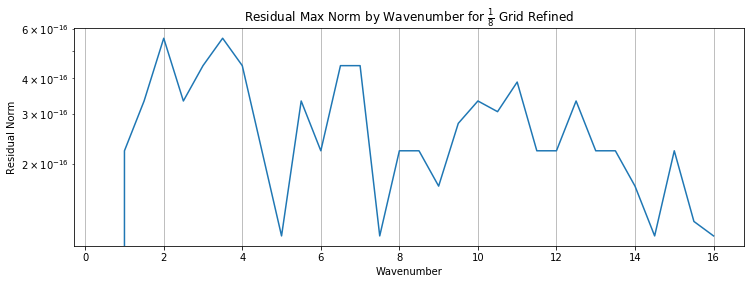

end loop i =  1


i =  2
[ 0.0389368   0.05827303  0.14112307  0.05845509  0.23924816 -0.04758942  0.23949379 -0.23949379  0.08417216 -0.42316203 -0.1975723  -0.47698173 -0.48826388 -0.32624749]
[ 0.0389368   0.05827303  0.14112307  0.05845509  0.23924816 -0.04758942  0.23949379 -0.23949379  0.08417216 -0.42316203 -0.1975723  -0.47698173 -0.48826388 -0.32624749]

[ 0.0389368   0.05827303  0.14112307  0.05845509  0.23924816 -0.04758942  0.23949379 -0.23949379  0.08417216 -0.42316203 -0.1975723  -0.47698173 -0.48826388 -0.32624749]
[ 0.0389368   0.05827303  0.14112307  0.05845509  0.23924816 -0.04758942  0.23949379 -0.23949379  0.08417216 -0.42316203 -0.1975723  -0.47698173 -0.48826388 -0.32624749]



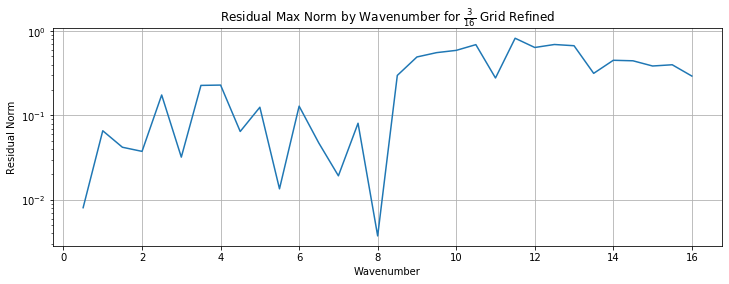

end loop i =  2


i =  3
[ 0.02194388  0.          0.03185673 -0.0663382  -0.07637773 -0.14112764 -0.27179134 -0.05406266 -0.32613733  0.2496147  -0.04459942  0.54130631  0.44389062  0.48046375]
[ 0.02194388  0.          0.03185673 -0.0663382  -0.07637773 -0.14112764 -0.27179134 -0.05406266 -0.32613733  0.2496147  -0.04459942  0.54130631  0.44389062  0.48046375]

[ 0.09894596  0.10135007  0.29077708  0.00726783  0.30742193 -0.28359265  0.0297767  -0.49346507 -0.317697   -0.38077479 -0.40708791 -0.05930401 -0.2175482   0.11627851]
[ 0.09894596  0.10135007  0.29077708  0.00726783  0.30742193 -0.28359265  0.0297767  -0.49346507 -0.317697   -0.38077479 -0.40708791 -0.05930401 -0.2175482   0.11627851]

[ 0.02194388  0.          0.03185673 -0.0663382  -0.07637773 -0.14112764 -0.27179134 -0.05406266 -0.32613733  0.2496147  -0.04459942  0.54130631  0.44389062  0.48046375]
[ 0.02194388  0.          0.03185673 -0.0663382  -0.07637773 -0.14112764 -0.27179134 -0.05406266 -0.32613733  0.2496147  -0

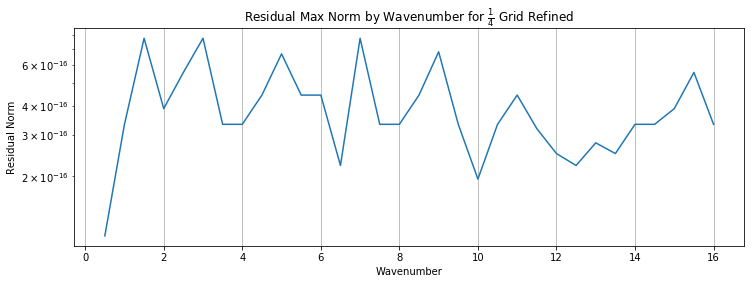

end loop i =  3


i =  4
[ 0.03017613  0.          0.         -0.07307922 -0.1419128  -0.00865372 -0.05690066  0.24250904  0.34325777  0.18576977  0.40011949 -0.36966221 -0.25284275 -0.63124866]
[ 0.03017613  0.          0.         -0.07307922 -0.1419128  -0.00865372 -0.05690066  0.24250904  0.34325777  0.18576977  0.40011949 -0.36966221 -0.25284275 -0.63124866]

[-0.0379683   0.01407794  0.          0.14297426  0.25189106  0.14639021  0.39377984 -0.19199374  0.09761354 -0.51644319 -0.31677351 -0.40188216 -0.39283831 -0.09325539]
[-0.0379683   0.01407794  0.          0.14297426  0.25189106  0.14639021  0.39377984 -0.19199374  0.09761354 -0.51644319 -0.31677351 -0.40188216 -0.39283831 -0.09325539]

[ 0.19683557  0.13753084  0.42620292 -0.15475805  0.14954899 -0.53661512 -0.30628585 -0.39552376 -0.29090898 -0.01785263 -0.05589682 -0.04278156 -0.19632551 -0.21846309]
[ 0.19683557  0.13753084  0.42620292 -0.15475805  0.14954899 -0.53661512 -0.30628585 -0.39552376 -0.29090898 -0.01785263 -0

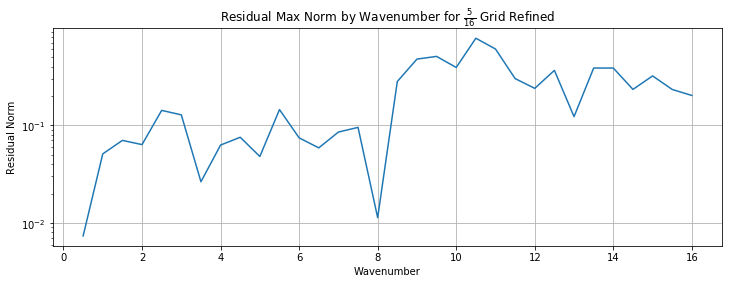

end loop i =  4


i =  5
[ 0.00618052  0.          0.          0.          0.04206457  0.00986974  0.06489631 -0.13513956 -0.24992247 -0.21187404 -0.45634409  0.30491937  0.22071044  0.71995141]
[ 0.00618052  0.          0.          0.          0.04206457  0.00986974  0.06489631 -0.13513956 -0.24992247 -0.21187404 -0.45634409  0.30491937  0.22071044  0.71995141]

[ 0.02909191  0.0125119   0.          0.          0.04766785  0.13161304  0.35988687  0.02436893  0.26441733 -0.49135236 -0.35123091 -0.48850513 -0.41858504  0.02707349]
[ 0.02909191  0.0125119   0.          0.          0.04766785  0.13161304  0.35988687  0.02436893  0.26441733 -0.49135236 -0.35123091 -0.48850513 -0.41858504  0.02707349]

[ 0.10986162  0.1190987   0.35759231  0.          0.32169856 -0.41228845 -0.15730124 -0.53047241 -0.35942906 -0.13783149 -0.10197531 -0.03161769 -0.20705672 -0.25258537]
[ 0.10986162  0.1190987   0.35759231  0.          0.32169856 -0.41228845 -0.15730124 -0.53047241 -0.35942906 -0.13783149 -0

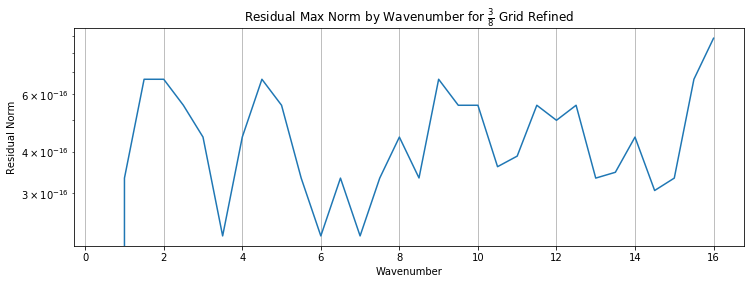

end loop i =  5


i =  6
[ 0.00371745  0.          0.          0.          0.         -0.01096911 -0.07212496  0.02987514  0.09216695  0.2354742   0.50717521 -0.1403702  -0.11254224 -0.80014514]
[ 0.00371745  0.          0.          0.          0.         -0.01096911 -0.07212496  0.02987514  0.09216695  0.2354742   0.50717521 -0.1403702  -0.11254224 -0.80014514]

[ 0.0153279   0.01019675  0.          0.          0.          0.10603246  0.28522432  0.12318193  0.38002515 -0.37408597 -0.22949012 -0.57877801 -0.46403706 -0.06746826]
[ 0.0153279   0.01019675  0.          0.          0.          0.10603246  0.28522432  0.12318193  0.38002515 -0.37408597 -0.22949012 -0.57877801 -0.46403706 -0.06746826]

[ 0.00751997  0.08866377  0.31216795  0.          0.         -0.51381445 -0.53085028  0.06043386  0.18644283  0.32820854  0.01207986 -0.28395229 -0.22765963  0.26474191]
[ 0.00751997  0.08866377  0.31216795  0.          0.         -0.51381445 -0.53085028  0.06043386  0.18644283  0.32820854  0

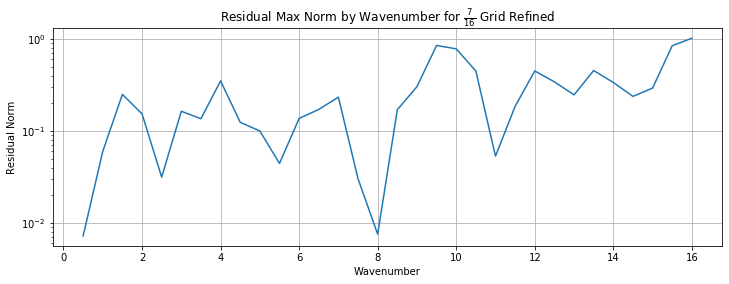

end loop i =  6


i =  7
[ 1.81890465e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  6.51167866e-14  1.46175411e-01  4.50961715e-01 -3.01938172e-13 -7.42476879e-13 -6.86814341e-01 -5.50655518e-01  1.23630949e-12]
[ 1.81890465e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  6.51167866e-14  1.46175411e-01  4.50961715e-01 -3.01938172e-13 -7.42476879e-13 -6.86814341e-01 -5.50655518e-01  1.23630949e-12]

[ 2.64417336e-14  1.09637664e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.42957824e-02  2.17288906e-13  6.68519104e-13  2.04519696e-01  5.02461850e-01 -1.01361878e-12 -8.08029620e-13 -8.38892404e-01]
[ 2.64417336e-14  1.09637664e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.42957824e-02  2.17288906e-13  6.68519104e-13  2.04519696e-01  5.02461850e-01 -1.01361878e-12 -8.08029620e-13 -8.38892404e-01]

[ 1.63211614e-15  7.37676547e-02  1.65670456e-01  0.00000000e+00  0.0

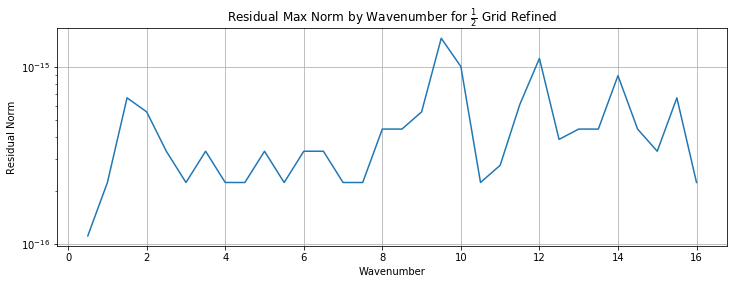

end loop i =  7


i =  8
[ 1.81890465e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.46175411e-01  4.50961715e-01  1.17865022e-13  5.37122544e-13 -6.86814341e-01 -5.50655518e-01 -1.17646753e-12]
[ 1.81890465e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.46175411e-01  4.50961715e-01  1.17865022e-13  5.37122544e-13 -6.86814341e-01 -5.50655518e-01 -1.17646753e-12]

[-0.0103671   0.00117961  0.          0.          0.          0.          0.         -0.03565624 -0.04910036 -0.09114587 -0.4137617  -0.00385261 -0.04521336  0.90257604]
[-0.0103671   0.00117961  0.          0.          0.          0.          0.         -0.03565624 -0.04910036 -0.09114587 -0.4137617  -0.00385261 -0.04521336  0.90257604]

[-0.09809408  0.09313129  0.16078526  0.          0.          0.          0.         -0.33738141 -0.46459046  0.39741212  0.492099   -0.03645366 -0.42781142  0.2042851 ]
[-0.0980940

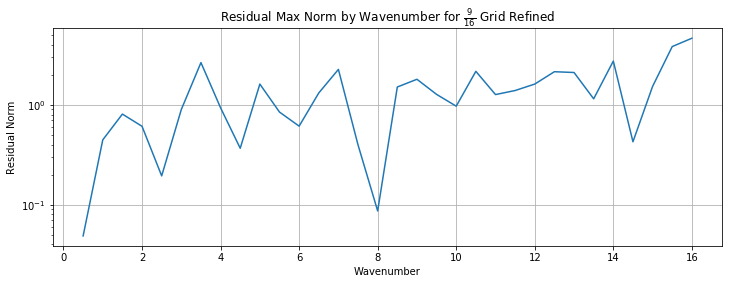

end loop i =  8


i =  9
[ 0.00306835  0.          0.          0.          0.          0.          0.          0.         -0.07268149  0.06161639  0.34916404  0.23330395  0.26453171 -0.8628952 ]
[ 0.00306835  0.          0.          0.          0.          0.          0.          0.         -0.07268149  0.06161639  0.34916404  0.23330395  0.26453171 -0.8628952 ]

[-0.0212164   0.0089446   0.          0.          0.          0.          0.          0.         -0.1008062  -0.21417752 -0.43465564  0.50636975  0.68631185  0.16454836]
[-0.0212164   0.0089446   0.          0.          0.          0.          0.          0.         -0.1008062  -0.21417752 -0.43465564  0.50636975  0.68631185  0.16454836]

[-0.19510446  0.21661026  0.30609748  0.          0.          0.          0.          0.          0.53645159 -0.08501993 -0.40855912 -0.48443286  0.21013008 -0.28383001]
[-0.19510446  0.21661026  0.30609748  0.          0.          0.          0.          0.          0.53645159 -0.08501993 -0

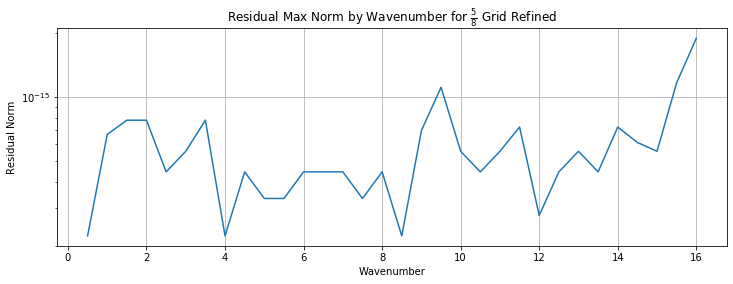

end loop i =  9


i =  10
[ 0.0085561   0.          0.          0.          0.          0.          0.          0.          0.          0.2121318   0.57034868 -0.32307657 -0.62534804 -0.3663204 ]
[ 0.0085561   0.          0.          0.          0.          0.          0.          0.          0.          0.2121318   0.57034868 -0.32307657 -0.62534804 -0.3663204 ]

[-0.0132296   0.00847611  0.          0.          0.          0.          0.          0.          0.         -0.01349267 -0.14365435 -0.23868229 -0.49457867  0.82301714]
[-0.0132296   0.00847611  0.          0.          0.          0.          0.          0.          0.         -0.01349267 -0.14365435 -0.23868229 -0.49457867  0.82301714]

[-0.50094594  0.48869858  0.53957219  0.          0.          0.          0.          0.          0.         -0.26568271  0.00200873  0.31032599 -0.22054456 -0.05962586]
[-0.50094594  0.48869858  0.53957219  0.          0.          0.          0.          0.          0.         -0.26568271  

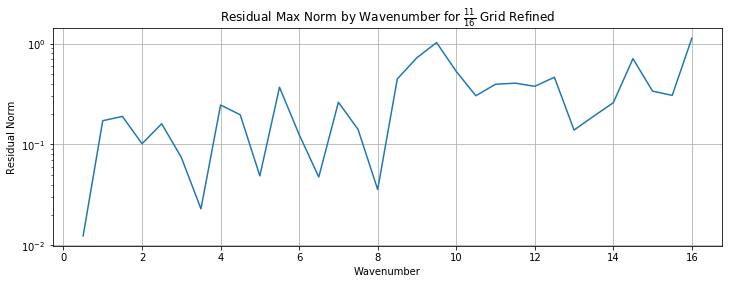

end loop i =  10


i =  11
[ 0.00429845  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.02181113  0.2647232   0.65421506 -0.70811728]
[ 0.00429845  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.02181113  0.2647232   0.65421506 -0.70811728]

[-0.04868276  0.04887216  0.          0.          0.          0.          0.          0.          0.          0.         -0.49501115  0.0116642   0.64167832  0.58165139]
[-0.04868276  0.04887216  0.          0.          0.          0.          0.          0.          0.          0.         -0.49501115  0.0116642   0.64167832  0.58165139]

[-5.77614609e-01  5.77614609e-01  5.66700879e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.07516371e-01 -2.94134340e-15 -2.55641632e-03 -2.55641632e-03]
[-5.77614609e-01  5.77614609e-01  5.66700879e-01  0.00000000e+00 

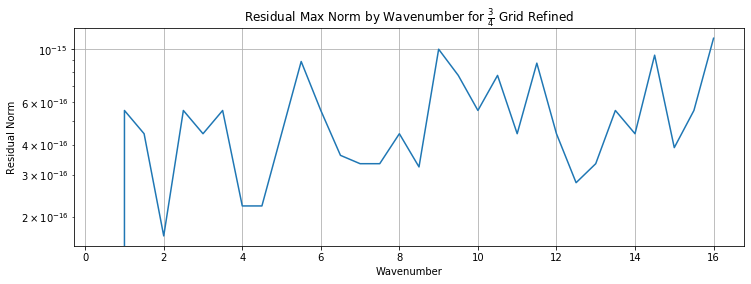

end loop i =  11


i =  12
[ 0.00351658  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.2596498   0.6857747  -0.67991373]
[ 0.00351658  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.2596498   0.6857747  -0.67991373]

[-0.18552347  0.2923573   0.          0.          0.          0.          0.          0.          0.          0.          0.          0.72532135 -0.53394801 -0.26251993]
[-0.18552347  0.2923573   0.          0.          0.          0.          0.          0.          0.          0.          0.          0.72532135 -0.53394801 -0.26251993]

[-0.55101548  0.53222309  0.56232015  0.          0.          0.          0.          0.          0.          0.          0.         -0.12728094  0.2241236   0.17459882]
[-0.55101548  0.53222309  0.56232015  0.          0.          0.          0.          0.          0.          0.         

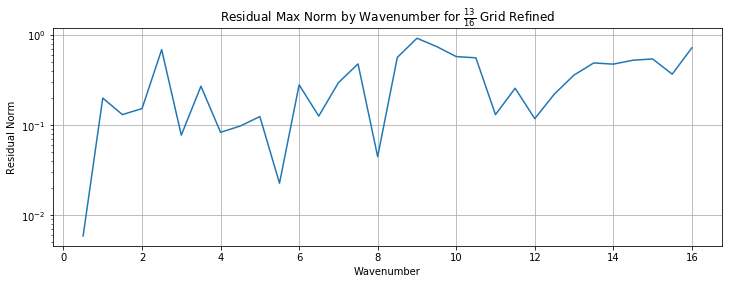

end loop i =  12


i =  13
[ 0.02568372  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.91718193 -0.3976401 ]
[ 0.02568372  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.91718193 -0.3976401 ]

[-0.1964342   0.47541886  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.34573293  0.78476701]
[-0.1964342   0.47541886  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.34573293  0.78476701]

[-0.55770729  0.38139029  0.65435999  0.          0.          0.          0.          0.          0.          0.          0.          0.         -0.12180994 -0.3169848 ]
[-0.55770729  0.38139029  0.65435999  0.          0.          0.          0.          0.          0.          0.         

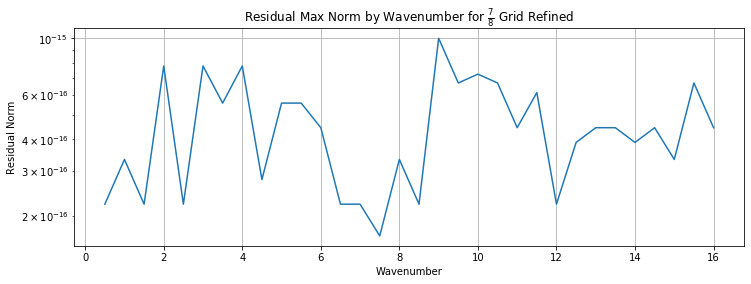

end loop i =  13


i =  14
[ 0.11850641  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.         -0.99295329]
[ 0.11850641  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.         -0.99295329]

[-0.19240195  0.9810475   0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.         -0.02296268]
[-0.19240195  0.9810475   0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.         -0.02296268]

[-0.5981367  -0.11897679  0.78929148  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.         -0.07138607]
[-0.5981367  -0.11897679  0.78929148  0.          0.          0.          0.          0.          0.          0.         

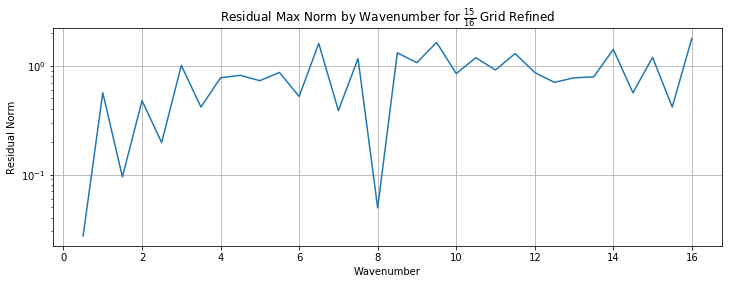

end loop i =  14


i =  15


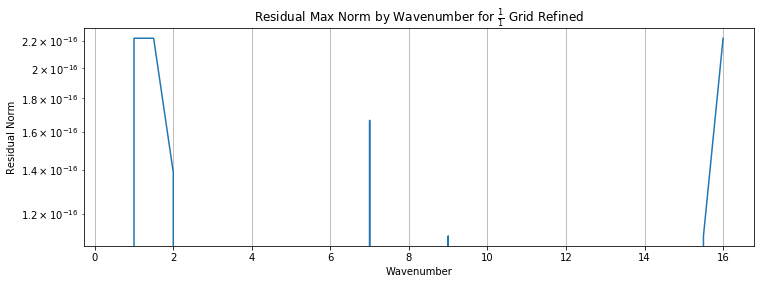

end loop i =  15




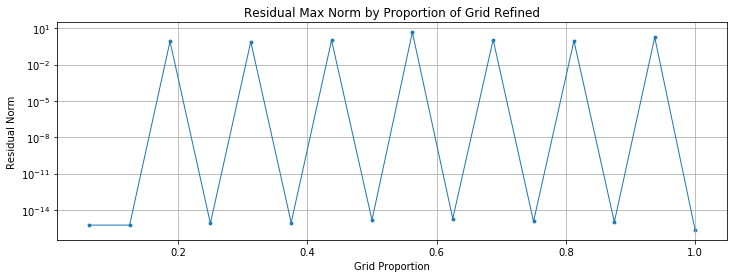

In [5]:
Residuals(omegaF, plot = plot)